<a href="https://colab.research.google.com/github/Xinsen-Zhang/torch-study/blob/master/09_adagrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adagrad

In [0]:
def sgd_adagrad(parameters, sqrs, lr):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = sqr + param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

# 倒包

In [0]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
from matplotlib import pyplot as plt
from torch.nn import init
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype= 'float32') / 255
    x = (x- 0.5) / 0.5
    x = x.reshape((-1,))
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train= True, transform= data_tf, download= True)
test_set = MNIST('./data', train= False, transform= data_tf, download= True)

# 定义loss
criterion = torch.nn.CrossEntropyLoss()

In [14]:
train_data = DataLoader(train_set, batch_size= 64, shuffle= True)
# 使用Sequential定义三层网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 使用Xavier初始化
for layer in net:
    if(isinstance(layer, nn.Linear)):
        init.xavier_uniform_(layer.weight)

# 将网络初始化到GPU上   
net.cuda()

# 初始化梯度平方
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data).cuda())
    
# 开始训练
losses = []
idx = 0
start = time.time()
for e in range(10): #训练10个epoch
    train_loss = 0
    for im, label in train_data:
        im = Variable(im.float()).cuda()
        label = Variable(label).cuda()
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), sqrs, 1e-2)
        # 记录误差
        train_loss += loss.data
        if (idx % 50 == 0):
            losses.append(loss.data)
        idx += 1
    print('epoch: {}, Train loss: {:.6f}'.format(e + 1, train_loss / len(train_set)))
end = time.time()
duration = end - start
print('使用时间: {:.5f} s'.format(duration))

epoch: 1, Train loss: 0.006799
epoch: 2, Train loss: 0.003757
epoch: 3, Train loss: 0.003115
epoch: 4, Train loss: 0.002739
epoch: 5, Train loss: 0.002470
epoch: 6, Train loss: 0.002270
epoch: 7, Train loss: 0.002115
epoch: 8, Train loss: 0.001986
epoch: 9, Train loss: 0.001887
epoch: 10, Train loss: 0.001791
使用时间: 80.04527 s


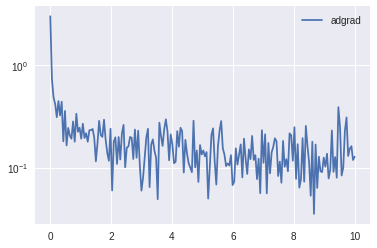

In [16]:
x_axis = np.linspace(0, 10, len(losses), endpoint= True)
plt.semilogy(x_axis, losses, label= 'adgrad')
plt.legend(loc='best')

# 使用内置的adamgrad优化器

In [17]:
train_data = DataLoader(train_set, batch_size= 64, shuffle= True)
# 使用Sequential定义三层网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 使用Xavier初始化
for layer in net:
    if(isinstance(layer, nn.Linear)):
        init.xavier_uniform_(layer.weight)

# 将网络初始化到GPU上   
net.cuda()

# 定义优化器
optimizer = torch.optim.Adagrad(net.parameters(), lr = 1e-2)

# 开始训练
losses1 = []
idx = 0
start = time.time()
for e in range(10): #训练10个epoch
    train_loss = 0
    for im, label in train_data:
        im = Variable(im.float()).cuda()
        label = Variable(label).cuda()
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录误差
        train_loss += loss.data
        if (idx % 50 == 0):
            losses1.append(loss.data)
        idx += 1
    print('epoch: {}, Train loss: {:.6f}'.format(e + 1, train_loss / len(train_set)))
end = time.time()
duration = end - start
print('使用时间: {:.5f} s'.format(duration))

epoch: 1, Train loss: 0.006630
epoch: 2, Train loss: 0.003583
epoch: 3, Train loss: 0.002985
epoch: 4, Train loss: 0.002629
epoch: 5, Train loss: 0.002378
epoch: 6, Train loss: 0.002200
epoch: 7, Train loss: 0.002041
epoch: 8, Train loss: 0.001918
epoch: 9, Train loss: 0.001815
epoch: 10, Train loss: 0.001728
使用时间: 68.11486 s


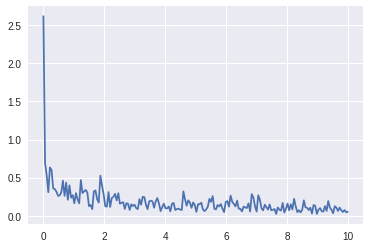

In [18]:
x_axis = np.linspace(0, 10, len(losses1), endpoint= True)
plt.plot(x_axis, losses1, label= 'adagrad')